In [2]:
from math import pi, e
import numpy as np

class kNN:
    def __init__(self, k, metric='cosine', metric_params=1, kernel='epanechnikov', use_parzen_window = True, window_size=None, prior_weights=None):
        self.k = k
        self.distance = metric
        self.metric_params = metric_params
        self.kernel = kernel
        self.window_size = window_size
        self.prior_weights = prior_weights
        self.use_parzen_window = use_parzen_window
        
    @staticmethod
    def minkowski(x, y, p):
        x = np.array(x)
        y = np.array(y)
        return np.sum(np.abs(x - y)**p)**(1 / p)

    @staticmethod
    def manhattan(x, y):
        return kNN.minkowski(x, y, 1)

    @staticmethod
    def euclidean(x, y):
        return kNN.minkowski(x, y, 2)

    @staticmethod
    def chebyshev(x, y):
        x = np.array(x)
        y = np.array(y)
        return np.max(np.abs(x - y))
    
    def apply_distance(self, x, y):
        if self.distance == 'euclidean':
            return self.euclidean(x, y)
        elif self.distance == 'manhattan':
            return self.manhattan(x, y)
        elif self.distance == 'chebyshev':
            return self.chebyshev(x, y)
        elif self.distance == 'minkowski':
            return self.minkowski(x, y, self.metric_params)
        else:
            raise ValueError("Expected minkowski with metric param, euclidean, chebyshev, manhattan or cosine distance")
        
    @staticmethod
    def uniform(u):
        if u < 1:
            return 0.5
        return 0
    
    @staticmethod
    def triangular(u):
        if u < 1:
            return (1 - abs(u))
        return 0
    
    @staticmethod
    def epanechnikov(u):
        if u < 1:
            return 3/4 * (1 - u ** 2)
        return 0
    
    @staticmethod
    def gaussian(u):
        return 1 / (2 * pi)**0.5 * e**(-0.5 * u**2)
    
    def apply_kernel(self, u, distance):
        if self.kernel == 'uniform':
            if not self.use_parzen_window and self.window_size is not None: 
                return self.uniform(u / self.window_size)
            else:
                return self.uniform(u / distance)
        elif self.kernel == 'triangular' :
            if not self.use_parzen_window and self.window_size is not None:
                return self.triangular(u / self.window_size)
            else:
                return self.triangular(u / distance)
        elif self.kernel == 'epanechnikov':
            if not self.use_parzen_window and self.window_size is not None:
                return self.epanechnikov(u / self.window_size)
            else:
                return self.epanechnikov(u / distance)
        elif self.kernel == 'gaussian':
            if not self.use_parzen_window and self.window_size is not None:
                return self.gaussian(u / self.window_size)
            else:
                return self.gaussian(u / distance)
        else:
            raise ValueError('Expected uniform, triangular, epanechnikov or gaussian  kernel')
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for test_point in X_test:
            neighbours = self.get_neighbours(test_point)
            if self.kernel is not None:
                prediction = [0] * 2
                for neighbour in neighbours:
                    prediction[neighbour[0]] += neighbour[1]
                max_value = max(prediction)
                y_pred.append(prediction.index(max_value))
            else:
                prediction = [neighbour[i][0] for i in range(len(neighbour))]
                max_value = max(set(prediction), key=prediction.count)
                y_pred.append(max_value)
        return y_pred

    def get_neighbours(self, test_point):
        distances = [(self.y_train[i], self.apply_distance(train_row, test_point)) for i, train_row in enumerate(self.X_train)]
        distances.sort(key=lambda tup: tup[1])
        if self.kernel is None :
            return distances
        else:
            weights = [(distances[i][0], self.apply_kernel(distances[i][1], distances[self.k + 1][1])) for i in range(len(distances))]
            weights.sort(key=lambda tup: tup[1], reverse=True)
            if self.prior_weights is not None:
                weights = [(weights[i][0], weights[i][1] * self.weights[i]) for i in range(len(weights))]
            neighbours = weights[:self.k]
            return neighbours

### Подготовка датасета


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("KNNAlgorithmDataset.csv")
data.fillna(0, inplace=True)

label_encoder = LabelEncoder()

X = data.drop("diagnosis", axis=1)
y = label_encoder.fit_transform(data["diagnosis"])

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.head(10)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,0.000915,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.000915,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0
2,0.092495,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0.0
3,0.092547,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0.0
4,0.092559,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0.0
5,0.000916,0.258839,0.202570,0.267984,0.141506,0.678613,0.461996,0.369728,0.402038,0.518687,...,0.312633,0.263908,0.136748,0.712739,0.482784,0.427716,0.598282,0.477035,0.454939,0.0
6,0.000917,0.533343,0.347311,0.523875,0.380276,0.379164,0.274891,0.264058,0.367793,0.370707,...,0.416844,0.511928,0.349194,0.482269,0.223448,0.302236,0.663918,0.295289,0.187853,0.0
7,0.092668,0.318472,0.376057,0.320710,0.184263,0.598267,0.445126,0.219447,0.297465,0.573737,...,0.429638,0.299766,0.174941,0.622268,0.330753,0.213898,0.534708,0.321506,0.393939,0.0
8,0.000918,0.284869,0.409537,0.302052,0.159618,0.674099,0.533157,0.435567,0.464861,0.651515,...,0.498667,0.277852,0.136183,0.654626,0.497531,0.430511,0.707904,0.554504,0.342123,0.0
9,0.092715,0.259312,0.484613,0.277659,0.140997,0.595558,0.675480,0.532568,0.424602,0.489899,...,0.763859,0.235271,0.129326,0.753682,1.000000,0.882588,0.759450,0.552139,1.000000,0.0


###  Настройка гиперпараметров для своей реализации

In [44]:
import optuna

def objective(trial):
    k = trial.suggest_int('k', 1, 20)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
    metric_params = trial.suggest_int('metric_params', 3, 10) if metric == 'mikowski' else 1
    kernel = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    use_parzen_window = trial.suggest_categorical('use_parzen_window', [True, False])
    window_size = trial.suggest_int('window_size', 5, 10) if not use_parzen_window else None
    
    knn = kNN(
        k=k, 
        metric=metric, 
        metric_params=metric_params,
        kernel=kernel, 
        use_parzen_window=use_parzen_window,
        window_size=window_size
    )
    knn.fit(X_train=X_train.values, y_train=y_train)
    
    y_pre = knn.predict(X_test.values)
    acc = accuracy_score(y_test, y_pre)
    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

best_params = study.best_params
print("Best hyperparameters:", best_params)
    

/Users/egor/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-11 02:44:15,405] A new study created in memory with name: no-name-64cb1d20-dbb8-4bb4-a63d-094f2b285db4
[I 2024-05-11 02:44:15,807] Trial 0 finished with value: 0.9649122807017544 and parameters: {'k': 20, 'metric': 'minkowski', 'kernel': 'epanechnikov', 'use_parzen_window': True}. Best is trial 0 with value: 0.9649122807017544.
[I 2024-05-11 02:44:16,203] Trial 1 finished with value: 0.9649122807017544 and parameters: {'k': 13, 'metric': 'minkowski', 'kernel': 'triangular', 'use_parzen_window': True}. Best is trial 0 with value: 0.9649122807017544.
[I 2024-05-11 02:44:16,604] Trial 2 finished with value: 0.9473684210526315 and parameters: {'k': 10, 'metric': 'chebyshev', 'kernel': 'triangular', 'use_parzen_window': Tru

Best hyperparameters: {'k': 6, 'metric': 'euclidean', 'kernel': 'uniform', 'use_parzen_window': False, 'window_size': 9}


### Настройка гиперпараметров для библиотечной реализации

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import optuna

def objective1(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
    
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors, 
        weights=weights,
        metric=metric
    )
    model.fit(X_train,  y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective1, n_trials=100)
best_params = study.best_params
print("Best hyperparameters:", best_params)

/Users/egor/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-11 18:04:46,606] A new study created in memory with name: no-name-84826642-37f6-4355-a90c-cae12104b7a1
[I 2024-05-11 18:04:46,693] Trial 0 finished with value: 0.956140350877193 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.956140350877193.
[I 2024-05-11 18:04:46,717] Trial 1 finished with value: 0.9649122807017544 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9649122807017544.
[I 2024-05-11 18:04:46,727] Trial 2 finished with value: 0.9736842105263158 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 with value: 0.9736842105263158.
[I 2024-0

Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan'}


### График зависимости функции ошибки от числа соседей на тестовом множестве


<function matplotlib.pyplot.show(close=None, block=None)>

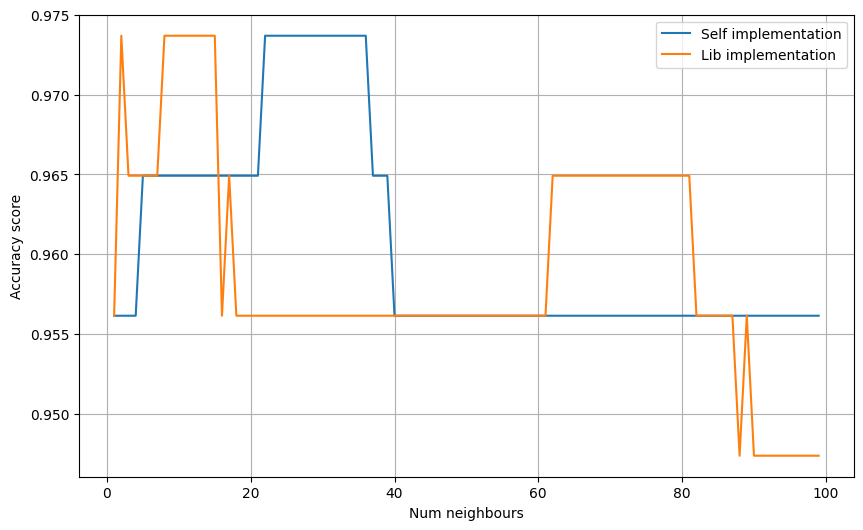

In [13]:
import matplotlib.pyplot as plt

k = list(range(1, 100))

plt.figure(figsize=(10, 6))
plt.xlabel('Num neighbours')
plt.ylabel('Accuracy score')
plt.grid(True)

self_implementation = list()
for i in range(1,100):
    knn_model = kNN(
        k=i, 
        metric='manhattan', 
        kernel='epanechnikov'
    )
    knn_model.fit(X_train=X_train.values, y_train=y_train)
    
    y_predict = knn_model.predict(X_test.values)
    accuracy = accuracy_score(y_test, y_predict)
    self_implementation.append(accuracy)
    
    
lib_implementation = list()
for i in range(1, 100):
    knn_model = KNeighborsClassifier(
        n_neighbors=i, 
        weights='uniform', 
        metric='manhattan'
    )
    knn_model.fit(X_train, y_train)
    
    y_pred = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    lib_implementation.append(accuracy)

plt.plot(k, self_implementation, label='Self implementation')
plt.plot(k, lib_implementation, label='Lib implementation')

plt.legend(loc="upper right")
plt.show()
